In [1]:
!nvidia-smi

Wed Apr 13 18:02:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from google.colab import files
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet169 #57 MB acc Top1 0.762 top5 0.932
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Screen/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/train/Vittiligo/_16_5139071.jpg  
  inflating: Dataset/train/Vittiligo/_16_5252102.jpg  
  inflating: Dataset/train/Vittiligo/_16_5692344.jpg  
  inflating: Dataset/train/Vittiligo/_16_6113465.jpg  
  inflating: Dataset/train/Vittiligo/_16_6295872.jpg  
  inflating: Dataset/train/Vittiligo/_16_6703006.jpg  
  inflating: Dataset/train/Vittiligo/_16_6805602.jpg  
  inflating: Dataset/train/Vittiligo/_16_7331465.jpg  
  inflating: Dataset/train/Vittiligo/_16_7692657.jpg  
  inflating: Dataset/train/Vittiligo/_16_8289253.jpg  
  inflating: Dataset/train/Vittiligo/_16_8328549.jpg  
  inflating: Dataset/train/Vittiligo/_16_8418756.jpg  
  inflating: Dataset/train/Vittiligo/_16_8539476.jpg  
  inflating: Dataset/train/Vittiligo/_16_8998487.jpg  
  inflating: Dataset/train/Vittiligo/_16_9551536.jpg  
  inflating: Dataset/train/Vittiligo/_16_9809609.jpg  
  inflating: Dataset/train/Vittiligo/_16_9982746.jpg  
  inflating: D

In [6]:
EPOCHS=100 #Number of epochs to train the model.
BATCH_SIZE =32 
CLASSES=5
PATIENCE=EPOCHS//5
LR_FACTOR=0.2
WEIGHTS_FILE = "weights.h5" #File that stores updated weights
image_size =224 #needs to comply with CNN input constraints. 
PATH="/content/Dataset" #Path to dataset
TEST_PATH='/content/Dataset/val'

In [7]:
#Necessary data preparation.
def data_prep():
    #Apply data augmentation on-the-fly on the training set to increase generalizability of the model.
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                                shear_range = 0.2,
                                                                zoom_range = 0.2,
                                                                width_shift_range = 0.2,
                                                                height_shift_range = 0.2,
                                                                fill_mode="nearest")
    #Create the pipeline
    train_data = train_datagen.flow_from_directory(os.path.join(PATH,"train"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    # Normalize validation dataset's image rgb values.
    valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
    #Create the pipeline
    valid_data = valid_datagen.flow_from_directory(os.path.join(PATH,"val"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    return[train_data,valid_data]

In [8]:
#Plot training learning curves for both train and validation.
def plot_training_curves(history):
        #Defining the metrics we will plot.
        train_acc=history.history['accuracy']
        val_acc=history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        #Range for the X axis.
        epochs = range(len(train_loss))
        
        fig,axis=plt.subplots(1,2,figsize=(20,8))#1 row, 2 col , width=20,height=8 inches.

        #Plotting Loss figures.
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.subplot(1,2,1) #plot 1st curve.
        plt.plot(epochs,train_loss,c="red",label="Training Loss") #plotting
        plt.plot(epochs,val_loss,c="blue",label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        #Plotting Accuracy figures. 
        plt.subplot(1,2,2) #plot 2nd curve.
        plt.plot(epochs,train_acc,c="red",label="Training Acc") #plotting
        plt.plot(epochs,val_acc,c="blue",label="Validation Acc")
        plt.xlabel("Epochs")   #title for x axis
        plt.ylabel("Accuracy") #title for y axis
        plt.legend()

In [15]:
#Make predictions on manually created test dataset folder. (OPTIONAL, different to initial dataset test set)
def test_model(path):
    i=0
    #Inversing class dictionary [keys,values]->[values,keys]
    labels = (train_data.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    for filename in os.listdir(path) :
        i+=1
        file_path= path +"/" + str(pathlib.Path(filename))
      
        image = tf.keras.preprocessing.image.load_img(
                file_path,grayscale=False, color_mode="rgb",
                target_size=(image_size,image_size), interpolation="nearest")
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr=input_arr/255
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        prediction = model.predict(input_arr)


        a=np.argmax(prediction)
        results = labels[a] 

        
        print("\n")
      # print("Predicted class number :", np.argmax(prediction))
        print("Actual class :" ,pathlib.Path(filename))
        print("predicted class name->  DenseNet169:",results )
        

    print("\n Tested: " ,i, "new unseen images")

In [16]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
      #Only save the weights that correspond to the minimum validation loss.
      tf.keras.callbacks.ModelCheckpoint(filepath=weights_file,
                                         monitor='val_accuracy',
                                         mode='max',
                                         save_best_only=True ,
                                         save_weights_only=True,
                                         verbose=0),
      #If val_loss doesn't improve for a number of epochs set with 'patience' 
      #variable, training will stop to avoid overfitting.    
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience,
                                       verbose=1),
      #Learning rate is reduced by 'lr_factor' if val_loss stagnates
      #for a number of epochs set with 'patience/2' variable.
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           factor=lr_factor,
                                           patience=patience//2,
                                           min_lr=1e-6,
                                           verbose=1)]

In [17]:
#The training class names.
class_names=['Acne_Disease', 'Eczema', 'Melanoma', 'Tinea', 'Vittiligo']

In [18]:
#Create the whole neural network, pass the base model as parameter.
def create_model(base_model):
      x = base_model.output
      #Add a global spatial average pooling layer.
      x = GlobalAveragePooling2D()(x)
      #Add a fully-connected layer.
      x = Dense(1024, activation='relu')(x)
      #Add a dropout layer to decrease overfitting
      x=Dropout(0.2)(x)
      #Add a logistic layer with number_of_neurons=number_of_training_classes.
      predictions = Dense(CLASSES, activation='softmax')(x)

      #This is the model we will train
      model = Model(inputs=base_model.input, outputs=predictions 
                                      ,name="Plant_Disease_Detector")

      #Freeze layers of the base model, we will only train the extra layers.
      #This way features already learned by the base model aren't lost.
      for layer in base_model.layers:
          layer.trainable = False

      #Assign a base learning rate for the Adam optimizer.
      base_learning_rate = 0.001
      model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)
                    ,loss='categorical_crossentropy' ,metrics='accuracy')
      
      return model

In [19]:
#Prepare data
train_data,valid_data=data_prep()
#Define callbacks for training
callbacks=assign_callbacks(WEIGHTS_FILE,PATIENCE,LR_FACTOR)

Found 13769 images belonging to 5 classes.
Found 2982 images belonging to 5 classes.


In [20]:
#Create the base pre-trained model, without the classification layers. 
base_model =DenseNet169(weights='imagenet',
                        include_top=False ,input_shape=(224,224,3))
#Create the complete new model.
model=create_model(base_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
#Information about the model's layers.
model.summary()

Model: "Plant_Disease_Detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                            

In [22]:
#Train the model on the dataset.
history=model.fit(x=train_data , batch_size=BATCH_SIZE,
                 epochs=EPOCHS , verbose=1 ,
                 validation_data=valid_data,
                 steps_per_epoch=20,
                 validation_steps=10,
                 callbacks=callbacks) 

Epoch 1/100
20/20 [==============================] - 37s 835ms/step - loss: 1.3374 - accuracy: 0.5219 - val_loss: 0.8276 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 12s 615ms/step - loss: 0.9173 - accuracy: 0.6406 - val_loss: 0.8521 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 13s 667ms/step - loss: 0.8336 - accuracy: 0.6703 - val_loss: 0.6793 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 12s 619ms/step - loss: 0.7824 - accuracy: 0.6766 - val_loss: 0.6737 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 14s 685ms/step - loss: 0.7391 - accuracy: 0.7078 - val_loss: 0.6040 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 13s 640ms/step - loss: 0.6975 - accuracy: 0.7344 - val_loss: 0.7203 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 14s 6

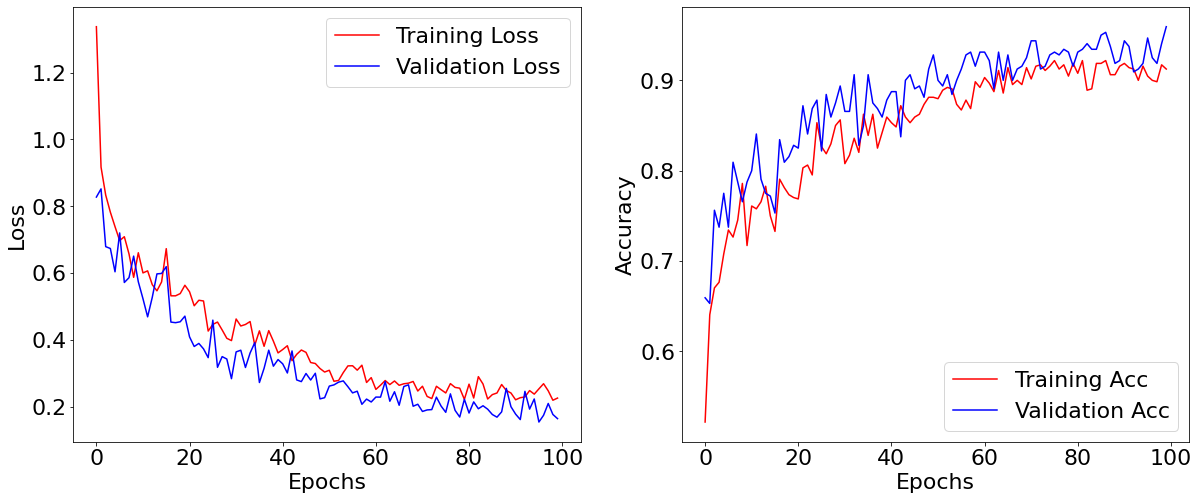

In [23]:
#Plot the Learning Curves from model training.
plot_training_curves(history)


In [24]:
#Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
#Convert the model to it's Tensorflow Lite equivalent
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT] ##Quantized
tflite_model = converter.convert()

# Save the model.
with open('model.tfliteQuant', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpf33ocfg_/assets


In [25]:
model.save('densenet169.h5') 

In [26]:
#Save the whole model for experimentations.
!mkdir -p saved_model 
model.save('saved_model/DenseNet169') 

# my_model directory
!ls saved_model
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/DenseNet169
# Zip it before download (So that you can download the whole directory at once )
!zip  -r /content/DenseNet169_In_Zip.zip /content/saved_model
print("Zip Ready")
# Download it 
files.download('/content/DenseNet169_In_Zip.zip')

INFO:tensorflow:Assets written to: saved_model/DenseNet169/assets


INFO:tensorflow:Assets written to: saved_model/DenseNet169/assets


DenseNet169
assets	keras_metadata.pb  saved_model.pb  variables
  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/DenseNet169/ (stored 0%)
  adding: content/saved_model/DenseNet169/keras_metadata.pb (deflated 96%)
  adding: content/saved_model/DenseNet169/saved_model.pb (deflated 93%)
  adding: content/saved_model/DenseNet169/variables/ (stored 0%)
  adding: content/saved_model/DenseNet169/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/DenseNet169/variables/variables.index (deflated 80%)
  adding: content/saved_model/DenseNet169/assets/ (stored 0%)
Zip Ready


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Restore an uploaded model for experimentations
files.upload()

!unzip -q /content/saved_model_In_Zip.zip 
new_model = tf.keras.models.load_model('/content/content/saved_model/MobileNetV2')
# Check its architecture
new_model.summary()

In [27]:
#Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
eval=model.evaluate(valid_data)
print(eval)


94/94 [==============================] - 27s 285ms/step - loss: 0.1908 - accuracy: 0.9319
[0.19080807268619537, 0.9319248795509338]


Following is our prediction:


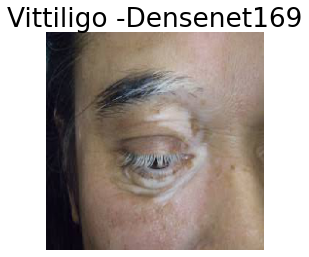

In [39]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "/content/images (59).jpeg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = class_names[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name+ " -Densenet169")
plt.show()